# Úvod

Dataset **_ECG200_** je elektrokardiografický dataset obsahující časové řady srdečních rytmů. Dataset zahrnuje 200 záznamů, kde každý záznam představuje jeden srdeční tep a má délku 96 časových bodů.

ECG200 je binární klasifikační problém, kde jsou data rozdělena do dvou tříd:
- Třída 0: **_Normální srdeční rytmus_**
- Třída 1: **_Abnormální srdeční rytmus_** (myokardiální infarkt)

Dataset je rozdělen na **_trénovací část_** (100 záznamů) a **_testovací část_** (100 záznamů). 


# Načtení knihoven


In [1]:
import os
import zipfile
import copy
from collections import defaultdict
import random

import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchinfo

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree

# Nastavení stejného seedu pro reprodukovatelnost


In [2]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Kontrola dostupnosti GPU


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPU")

GPU: NVIDIA GeForce RTX 2070


# Načtení a stažení dat


In [4]:
dataset_path = "../../datasets/ECG200/"
url = "https://www.timeseriesclassification.com/aeon-toolkit/ECG200.zip"
zip_file_name = "ECG200.zip"

In [5]:
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

    print(f"Downloading dataset from {url}...")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024

    zip_path = os.path.join(dataset_path, zip_file_name)
    with open(zip_path, "wb") as f:
        progress_bar = tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading")
        for data in response.iter_content(block_size):
            f.write(data)
            progress_bar.update(len(data))

    print("Extracting files...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        for file in tqdm(file_list, desc="Extracting"):
            zip_ref.extract(file, dataset_path)

    # Remove zip file
    os.remove(zip_path)
    print("Download and extraction complete!")
else:
    print(f"Dataset already exists at {dataset_path}")

Dataset already exists at ../../datasets/ECG200/


## Převedení dat do Pandas DataFrame


In [6]:
train_arff_path = "../../datasets/ECG200/ECG200_TRAIN.arff"
test_arff_path = "../../datasets/ECG200/ECG200_TEST.arff"

In [7]:
arff_train_file, _ = arff.loadarff(train_arff_path)
arff_test_file, _ = arff.loadarff(test_arff_path)

In [8]:
df_train = pd.DataFrame(arff_train_file)
df_test = pd.DataFrame(arff_test_file)

# Zobrazení dat


In [9]:
print(f"Train shape: {df_train.shape}\nTest shape: {df_test.shape}")

Train shape: (100, 97)
Test shape: (100, 97)


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 97 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   att1    100 non-null    float64
 1   att2    100 non-null    float64
 2   att3    100 non-null    float64
 3   att4    100 non-null    float64
 4   att5    100 non-null    float64
 5   att6    100 non-null    float64
 6   att7    100 non-null    float64
 7   att8    100 non-null    float64
 8   att9    100 non-null    float64
 9   att10   100 non-null    float64
 10  att11   100 non-null    float64
 11  att12   100 non-null    float64
 12  att13   100 non-null    float64
 13  att14   100 non-null    float64
 14  att15   100 non-null    float64
 15  att16   100 non-null    float64
 16  att17   100 non-null    float64
 17  att18   100 non-null    float64
 18  att19   100 non-null    float64
 19  att20   100 non-null    float64
 20  att21   100 non-null    float64
 21  att22   100 non-null    float64
 22  att

In [11]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att88,att89,att90,att91,att92,att93,att94,att95,att96,target
0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,0.380282,...,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765,b'-1'
1,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,-1.179593,...,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024,b'1'
2,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,0.499957,...,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347,b'-1'
3,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,0.989227,...,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540,b'-1'
4,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,0.701402,...,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190,b'1'


## Převod dat na číselný formát

Nyní máme cílovou proměnnou ve formátu _bytes_, tak si jej převedeme na _int_.


In [12]:
df_train['target'] = df_train['target'].astype(int)
df_test['target'] = df_test['target'].astype(int)

## Rovnováha tříd

### Rozložení tříd v trénovací sadě


In [13]:
df_train.target.value_counts()

target
 1    69
-1    31
Name: count, dtype: int64

### Rozložení tříd v testovací sadě


In [14]:
df_test.target.value_counts()

target
 1    64
-1    36
Name: count, dtype: int64

## Medián


In [15]:
df_train.groupby('target').mean()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att87,att88,att89,att90,att91,att92,att93,att94,att95,att96
target,,,,,,,,,,,,,,,,,,,,,
-1,0.905822,1.387498,1.511354,1.649614,1.532282,1.166005,0.910993,0.590077,0.264655,-0.030743,...,0.411426,0.463161,0.478292,0.612088,0.774617,0.858073,0.765151,0.713821,0.644889,0.423134
1,0.619758,1.437720,2.276275,2.340688,1.560302,0.580854,0.000347,0.218414,0.421638,0.319274,...,0.091116,0.044501,0.082371,0.140198,0.249758,0.280252,0.221240,0.089246,-0.024763,0.063321


In [16]:
df_train['target'] = df_train['target'].replace({-1: 0, 1: 1})
df_test['target'] = df_test['target'].replace({-1: 0, 1: 1})

In [17]:
y_train = df_train['target'].values
y_test = df_test['target'].values

In [18]:
print("Unique values in Y_train:", np.unique(y_train))
print("Unique values in Y_test:", np.unique(y_test))

Unique values in Y_train: [0 1]
Unique values in Y_test: [0 1]


# Vizualizace dat


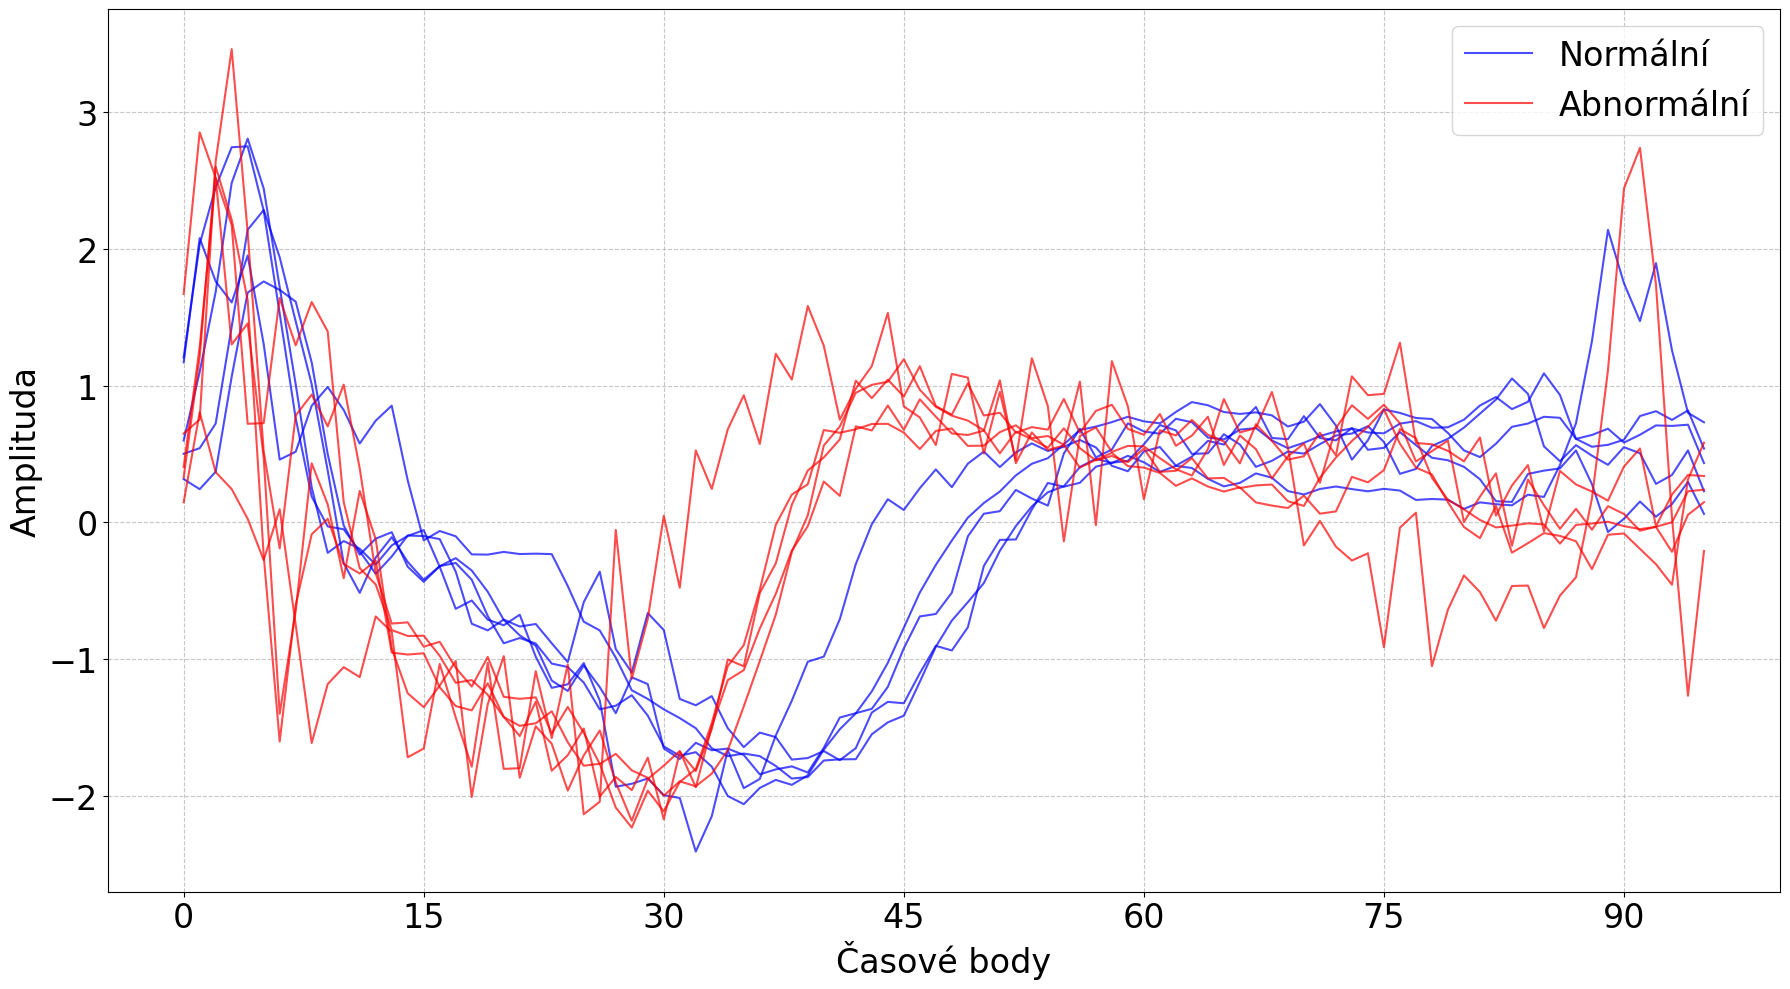

In [19]:
plt.figure(figsize=(18, 10))

normal_indices = [i for i, target in enumerate(df_train['target']) if target == 0]
abnormal_indices = [i for i, target in enumerate(df_train['target']) if target == 1]

for idx in normal_indices[:5]:
    plt.plot(df_train.iloc[idx, :-1].values, 'b-', alpha=0.7, label='Normální' if idx == normal_indices[0] else "")

for idx in abnormal_indices[:5]:
    plt.plot(df_train.iloc[idx, :-1].values, 'r-', alpha=0.7, label='Abnormální' if idx == abnormal_indices[0] else "")

font_size = 24

plt.legend(fontsize=font_size)

plt.xticks(range(0, 96, 15), fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.xlabel('Časové body', fontsize=font_size)
plt.ylabel('Amplituda', fontsize=font_size)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Příprava dat


In [20]:
X_train = df_train.drop(columns='target').values
y_train = df_train['target'].values
X_test = df_test.drop(columns='target').values
y_test = df_test['target'].values

print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}")

X_train shape: (100, 96)
X_test shape: (100, 96)
y_train shape: (100,)
y_test shape: (100,)


# Klasifikace pomocí strojového učení


## Decision Tree


In [21]:
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, zero_division=0))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        36
           1       0.86      0.86      0.86        64

    accuracy                           0.82       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.82      0.82      0.82       100



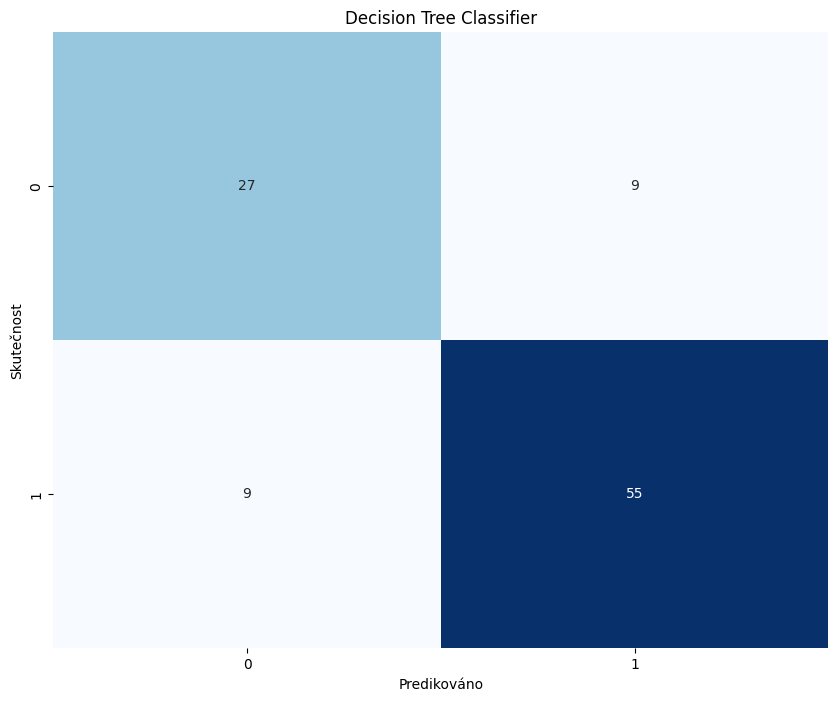

In [23]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predikováno')
plt.ylabel('Skutečnost')
plt.title('Decision Tree Classifier')
plt.show()

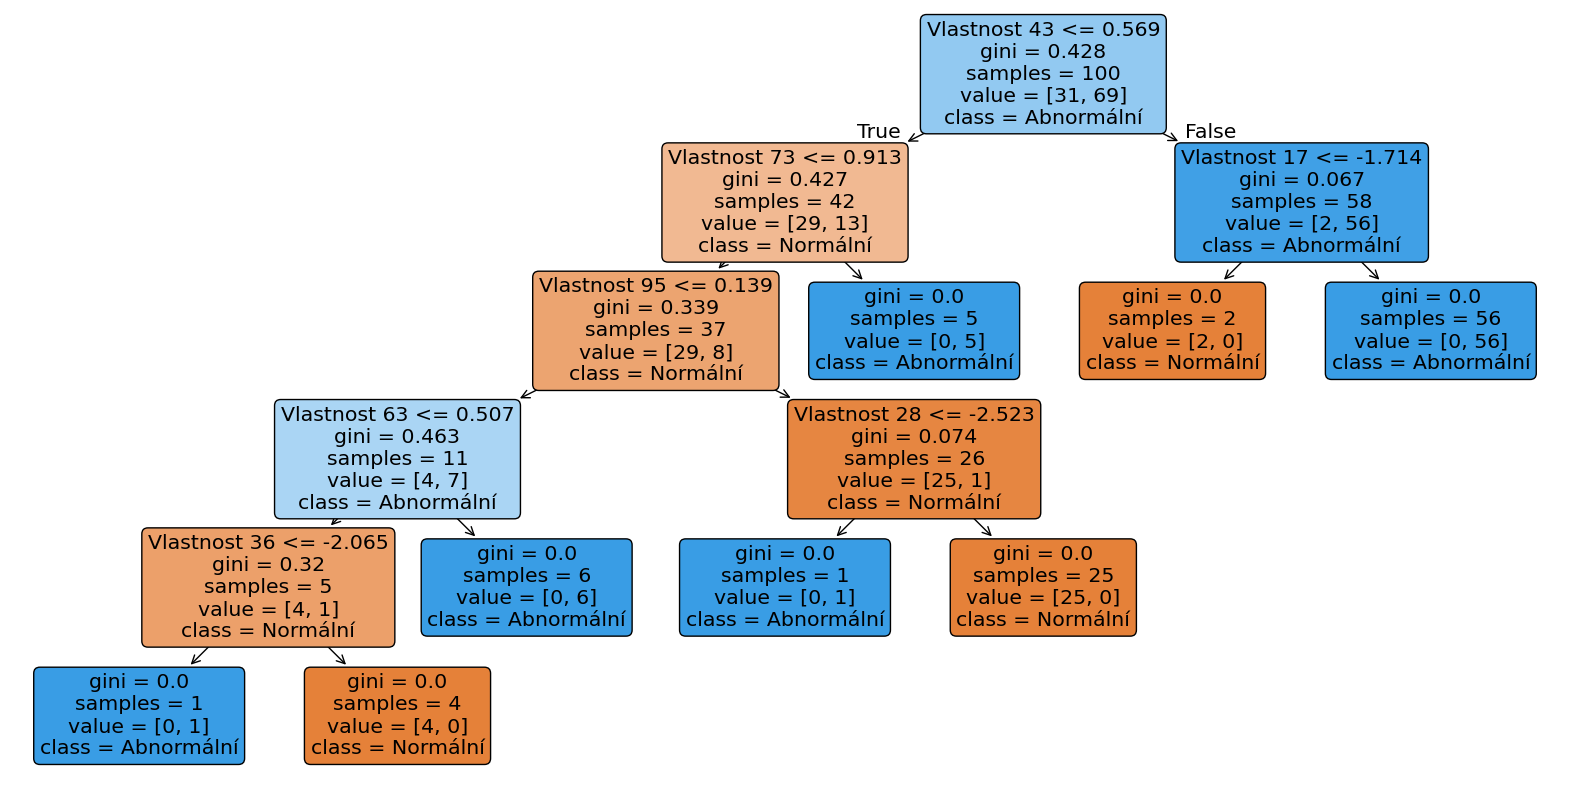

In [24]:
plt.figure(figsize=(20, 10), facecolor='white')
plot_tree(
    dt,
    feature_names=[f"Vlastnost {i}" for i in range(X_train.shape[1])],
    class_names=["Normální", "Abnormální"],
    filled=True,
    rounded=True
)
plt.show()

## Random Forest


In [24]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, zero_division=0))
cm_rf = confusion_matrix(y_test, y_pred_rf)

              precision    recall  f1-score   support

           0       0.81      0.61      0.70        36
           1       0.81      0.92      0.86        64

    accuracy                           0.81       100
   macro avg       0.81      0.77      0.78       100
weighted avg       0.81      0.81      0.80       100



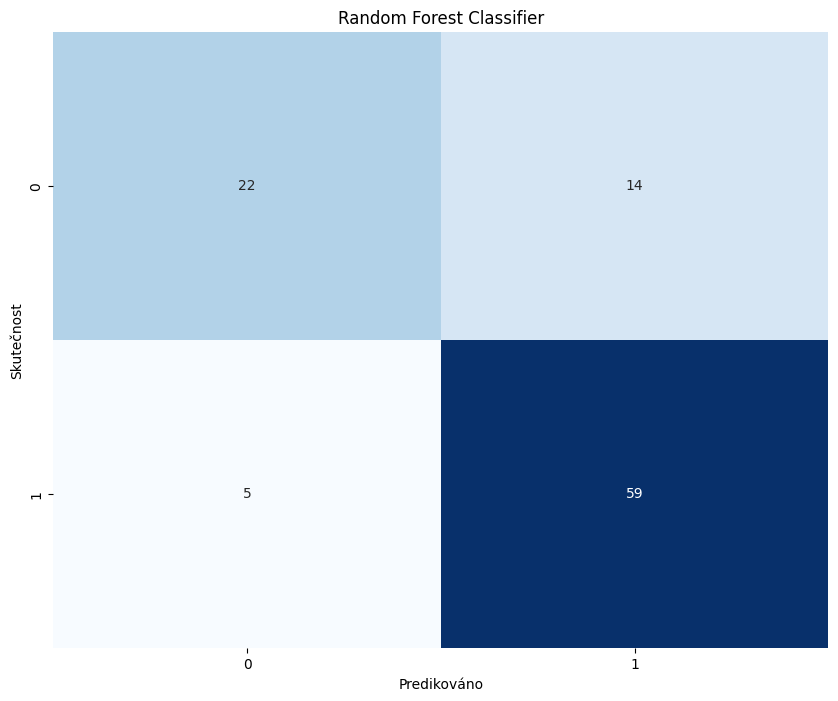

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predikováno')
plt.ylabel('Skutečnost')
plt.title('Random Forest Classifier')
plt.show()

## Gradient Boosting


In [27]:
gb = GradientBoostingClassifier(random_state=seed)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [28]:
y_pred_gb = gb.predict(X_test)
print(classification_report(y_test, y_pred_gb, zero_division=0))

              precision    recall  f1-score   support

           0       0.77      0.67      0.72        36
           1       0.83      0.89      0.86        64

    accuracy                           0.81       100
   macro avg       0.80      0.78      0.79       100
weighted avg       0.81      0.81      0.81       100



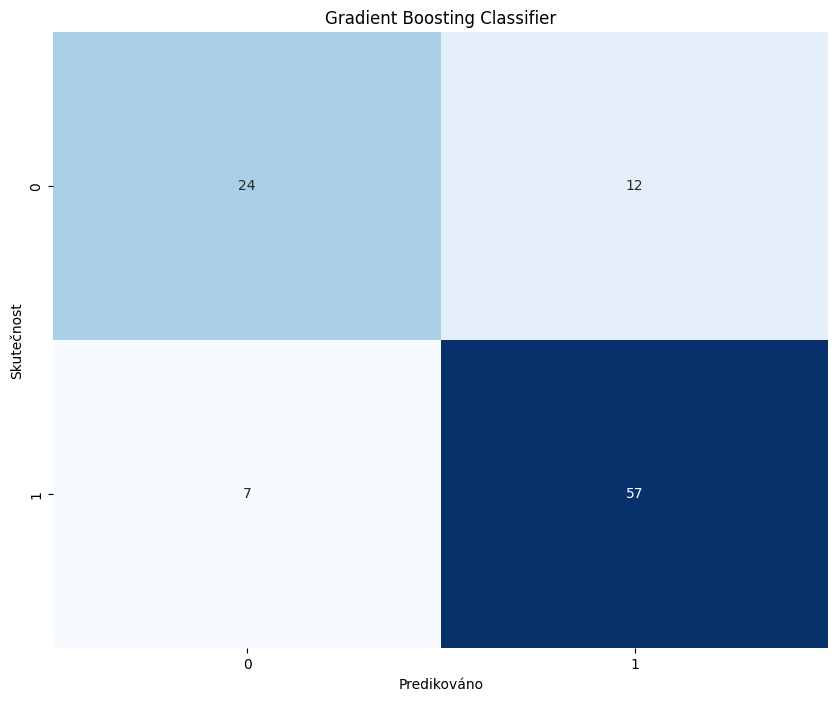

In [29]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predikováno')
plt.ylabel('Skutečnost')
plt.title('Gradient Boosting Classifier')
plt.show()

# Klasifikace pomocí neuronové sítě


## Pomocné funkce


### Funkce pro trénování modelu


In [30]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Print header
    print(f"{'Epoch':<7} | {'Train Loss':<12} | {'Train Acc':<10} | Improvement")
    print("-" * 50)

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total_samples = 0

        # Training phase
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Map from -1/1 to 0/1 for classification
            labels = (labels + 1) // 2  # Convert from [-1,1] to [0,1]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += inputs.size(0)

        # Calculate metrics
        epoch_loss = train_loss / total_samples
        epoch_acc = train_correct / total_samples

        # Store metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Check for improvement
        improvement = ""
        if epoch_acc > best_acc:
            improvement = "✓"
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"{epoch + 1:>3}/{num_epochs:<3} | {epoch_loss:>10.4f} | {epoch_acc:>9.2%} | {improvement}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete! Best accuracy: {best_acc:.2%}")

    return model, history

### Funkce pro vykreslení průběhu učení


In [31]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Trénovací ztráta')
    plt.xlabel('Epocha')
    plt.ylabel('Ztráta')
    plt.legend()
    plt.title('Ztráta během epoch')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Trénovací přesnost')
    plt.xlabel('Epocha')
    plt.ylabel('Přesnost')
    plt.legend()
    plt.title('Přesnost během epoch')

    plt.tight_layout()
    plt.show()

### Funkce pro vyhodnocení modelu


In [32]:
def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, prediction = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
        digits=4,
        zero_division=1,
        output_dict=True
    )

    # Print results
    print(f"\n{' Test Results ':=^40}")
    print(f"Overall Accuracy: {accuracy:.2%}\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4, zero_division=1))

    # Plot confusion matrix if class_names are provided
    if class_names:
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title('Matice záměny')
        plt.xlabel('Predikce')
        plt.ylabel('Skutečné hodnoty')
        plt.tight_layout()
        plt.show()

    # Return metrics dictionary
    metrics = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score']
    }

    return metrics

## Příprava dat pro neuronovou síť


In [33]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

In [34]:
# Reshape test data
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32).to(device)

X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32).to(device)

### Parametry pro trénování


In [35]:
batch_size = 16
num_epochs = 50
learning_rate = 0.001
num_classes = len(np.unique(y_train))
class_names = ["Normal", "Abnormal"] 

In [36]:
input_size = 1
hidden_size = 64
num_layers = 3
dropout = 0.5

### DataLoader


In [37]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [38]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
print(f"Input shape: [batch_size, channels, sequence_length] = [{batch_size}, {X_train_reshaped.shape[1]}, {X_train_reshaped.shape[2]}]")

Input shape: [batch_size, channels, sequence_length] = [16, 1, 96]


## Trénování jednotlivých modelů


### RNN


In [40]:
class RNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(RNNModel, self).__init__()
        
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # RNN Temporal Processor
        self.rnn = nn.RNN(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            nonlinearity='relu'
        )
        
        # Classifier Head with Sigmoid
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes),
            nn.Sigmoid() 
        )

    
    def forward(self, x):
        # CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove the last dimension 
        
        # RNN Processing - add a sequence dimension
        cnn_features = cnn_features.unsqueeze(1)  # [batch, 1, features]
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 2 layers
        rnn_out, _ = self.rnn(cnn_features, h0)
        rnn_features = rnn_out[:, -1, :]  # Last timestep
        
        # Classification
        logits = self.classifier(rnn_features)
        return logits

In [41]:
model = RNNModel(input_size, num_classes).to(device)
torchinfo.summary(
    model,
    input_size=(
        batch_size,
        input_size,
        X_train.shape[1]),
    col_names=[
            "input_size",
            "output_size",
        "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
RNNModel                                 [16, 1, 96]               [16, 2]                   --
├─Sequential: 1-1                        [16, 1, 96]               [16, 256, 1]              --
│    └─Conv1d: 2-1                       [16, 1, 96]               [16, 64, 96]              512
│    └─BatchNorm1d: 2-2                  [16, 64, 96]              [16, 64, 96]              128
│    └─ReLU: 2-3                         [16, 64, 96]              [16, 64, 96]              --
│    └─MaxPool1d: 2-4                    [16, 64, 96]              [16, 64, 48]              --
│    └─Conv1d: 2-5                       [16, 64, 48]              [16, 128, 48]             41,088
│    └─BatchNorm1d: 2-6                  [16, 128, 48]             [16, 128, 48]             256
│    └─ReLU: 2-7                         [16, 128, 48]             [16, 128, 48]             --
│    └─MaxPool1d: 2-8       

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
rnn_model, rnn_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6857 |    57.00% | ✓
  2/50  |     0.6191 |    69.00% | ✓
  3/50  |     0.5867 |    69.00% | 
  4/50  |     0.5528 |    69.00% | 
  5/50  |     0.5270 |    69.00% | 
  6/50  |     0.5114 |    80.00% | ✓
  7/50  |     0.5050 |    81.00% | ✓
  8/50  |     0.4957 |    85.00% | ✓
  9/50  |     0.4987 |    86.00% | ✓
 10/50  |     0.4720 |    88.00% | ✓
 11/50  |     0.4646 |    87.00% | 
 12/50  |     0.4642 |    87.00% | 
 13/50  |     0.4091 |    93.00% | ✓
 14/50  |     0.4202 |    90.00% | 
 15/50  |     0.4011 |    91.00% | 
 16/50  |     0.3907 |    93.00% | 
 17/50  |     0.3847 |    93.00% | 
 18/50  |     0.3693 |    93.00% | 
 19/50  |     0.3760 |    94.00% | ✓
 20/50  |     0.3578 |    96.00% | ✓
 21/50  |     0.3765 |    93.00% | 
 22/50  |     0.3605 |    95.00% | 
 23/50  |     0.3448 |    97.00% | ✓
 24/50  |     0.3522 |    97.00% | 
 25/50  |     0.3584 |  

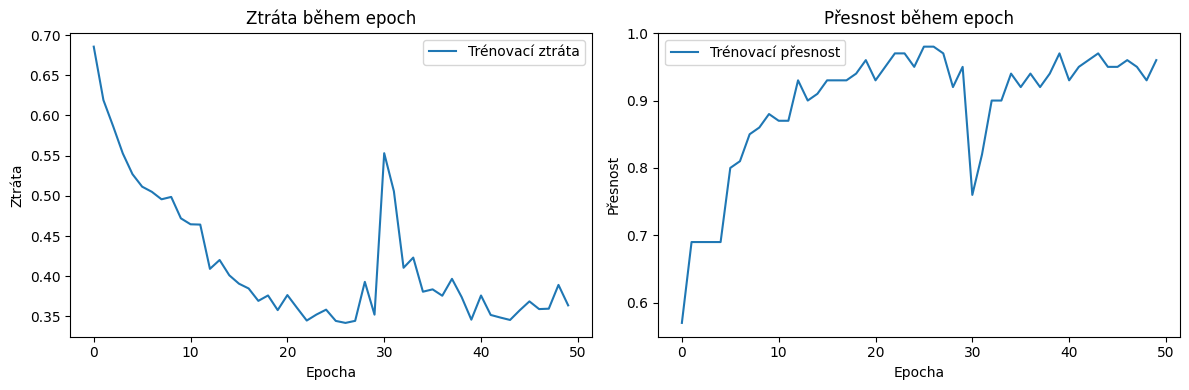

In [44]:
plot_training_history(rnn_history)


============= Test Results =============
Overall Accuracy: 87.00%

Classification Report:
              precision    recall  f1-score   support

      Normal     0.8286    0.8056    0.8169        36
    Abnormal     0.8923    0.9062    0.8992        64

    accuracy                         0.8700       100
   macro avg     0.8604    0.8559    0.8581       100
weighted avg     0.8694    0.8700    0.8696       100



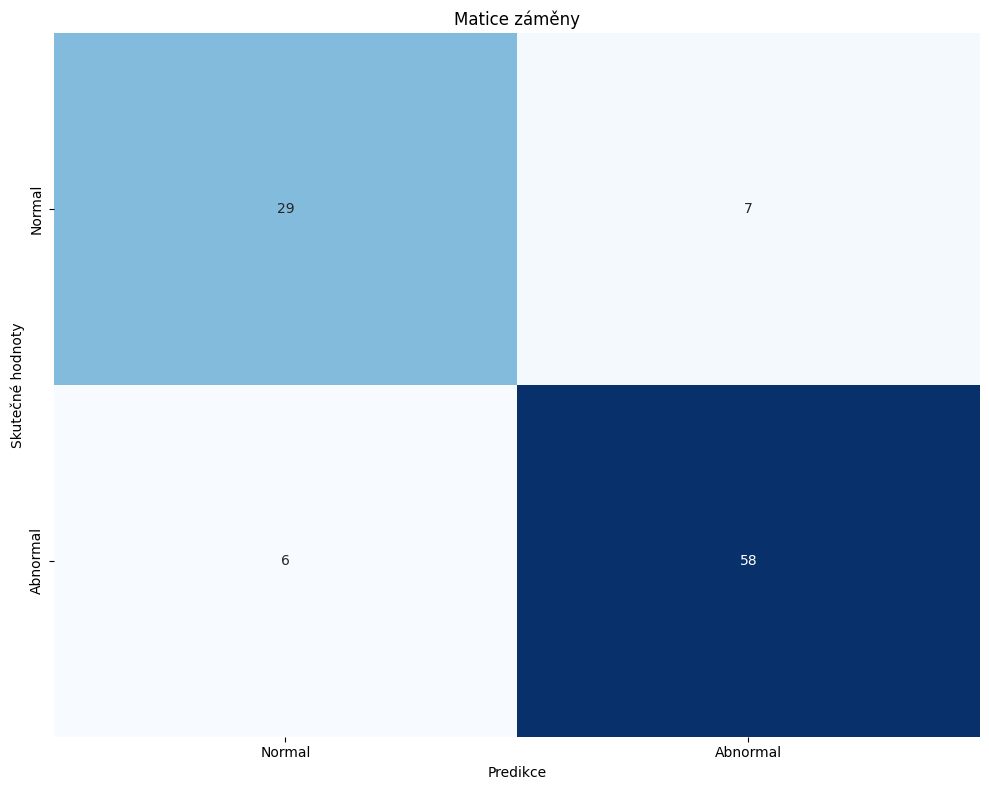

In [45]:
rnn_metrics = evaluate_model(rnn_model, test_loader, device, class_names)

### GRU

In [46]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(GRUModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. GRU Temporal Processor
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),

            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for GRU (add sequence dimension back)
        gru_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. GRU Processing
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        gru_out, _ = self.gru(gru_input, h0)
        gru_out = gru_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(gru_out)
        return logits

In [47]:
gru_model = GRUModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(
    gru_model,
    input_size=(
        batch_size,
        input_size,
        X_train.shape[1]),
    col_names=[
            "input_size",
            "output_size",
            "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
GRUModel                                 [16, 1, 96]               [16, 2]                   --
├─Sequential: 1-1                        [16, 1, 96]               [16, 64, 1]               --
│    └─Conv1d: 2-1                       [16, 1, 96]               [16, 64, 96]              512
│    └─BatchNorm1d: 2-2                  [16, 64, 96]              [16, 64, 96]              128
│    └─ReLU: 2-3                         [16, 64, 96]              [16, 64, 96]              --
│    └─MaxPool1d: 2-4                    [16, 64, 96]              [16, 64, 48]              --
│    └─Conv1d: 2-5                       [16, 64, 48]              [16, 128, 48]             41,088
│    └─BatchNorm1d: 2-6                  [16, 128, 48]             [16, 128, 48]             256
│    └─ReLU: 2-7                         [16, 128, 48]             [16, 128, 48]             --
│    └─MaxPool1d: 2-8       

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
gru_model, gru_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.3484 |    97.00% | ✓
  2/50  |     0.3392 |    98.00% | ✓
  3/50  |     0.3526 |    96.00% | 
  4/50  |     0.3428 |    97.00% | 
  5/50  |     0.3707 |    93.00% | 
  6/50  |     0.3688 |    94.00% | 
  7/50  |     0.3929 |    91.00% | 
  8/50  |     0.3447 |    96.00% | 
  9/50  |     0.3907 |    92.00% | 
 10/50  |     0.3619 |    95.00% | 
 11/50  |     0.3472 |    96.00% | 
 12/50  |     0.3593 |    95.00% | 
 13/50  |     0.3469 |    96.00% | 
 14/50  |     0.3455 |    97.00% | 
 15/50  |     0.3721 |    94.00% | 
 16/50  |     0.3435 |    96.00% | 
 17/50  |     0.3191 |   100.00% | ✓
 18/50  |     0.3222 |    99.00% | 
 19/50  |     0.3145 |   100.00% | 
 20/50  |     0.3478 |    96.00% | 
 21/50  |     0.3435 |    97.00% | 
 22/50  |     0.3221 |    99.00% | 
 23/50  |     0.3184 |    99.00% | 
 24/50  |     0.3238 |    99.00% | 
 25/50  |     0.3476 |    96.00%

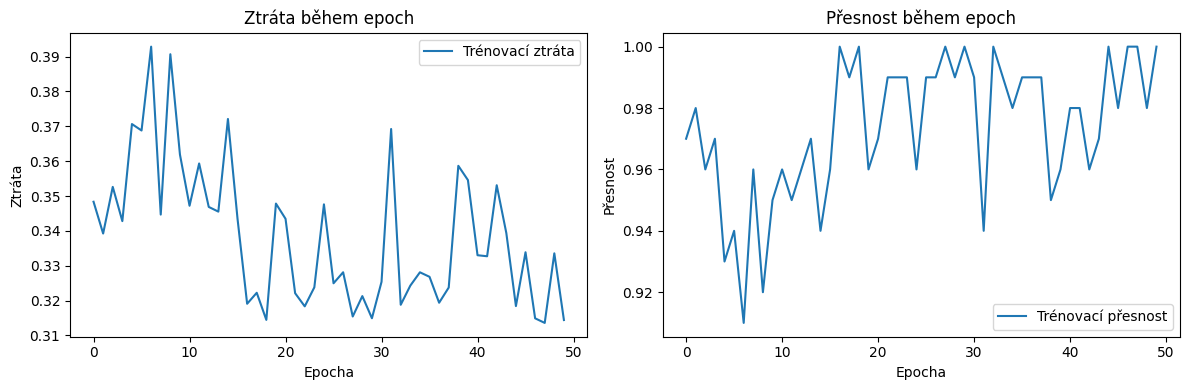

In [50]:
plot_training_history(gru_history)


============= Test Results =============
Overall Accuracy: 86.00%

Classification Report:
              precision    recall  f1-score   support

      Normal     0.8235    0.7778    0.8000        36
    Abnormal     0.8788    0.9062    0.8923        64

    accuracy                         0.8600       100
   macro avg     0.8512    0.8420    0.8462       100
weighted avg     0.8589    0.8600    0.8591       100



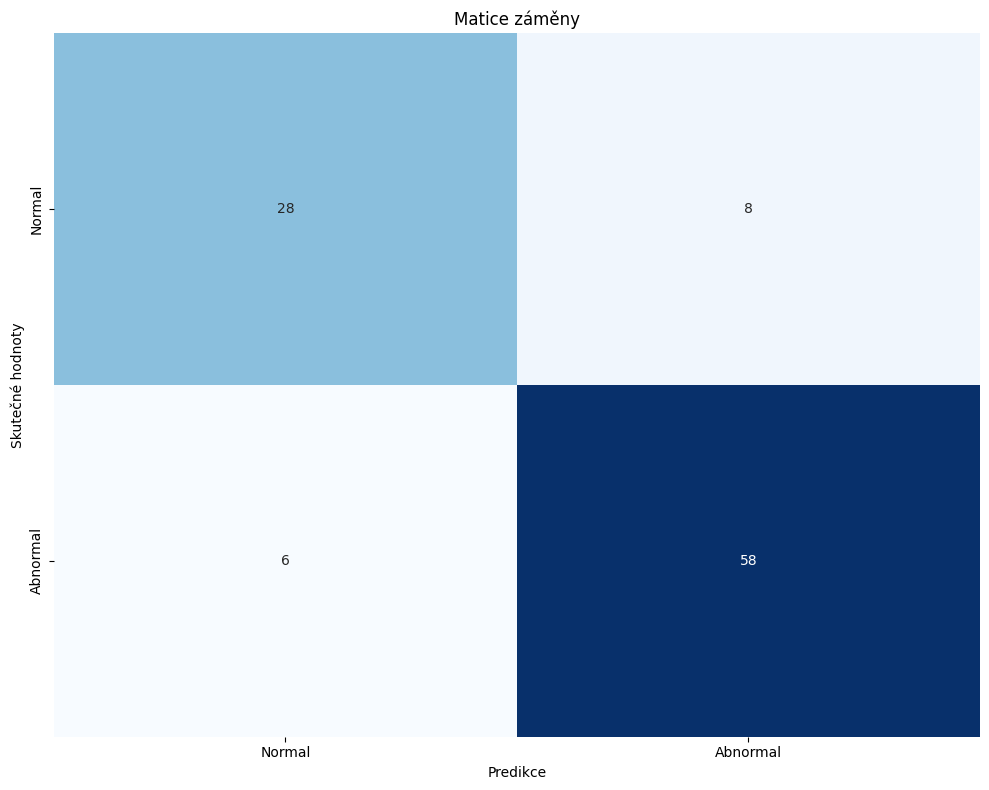

In [51]:
gru_metrics = evaluate_model(gru_model, test_loader, device, class_names)

### LSTM

In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(LSTMModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. LSTM Processor
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()  # Added Sigmoid activation
        )

    def forward(self, x):            
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for LSTM (add sequence dimension back)
        lstm_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. LSTM Processing
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))
        lstm_out = lstm_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(lstm_out)
        return logits

In [53]:
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [16, 1, 96]               [16, 2]                   --
├─Sequential: 1-1                        [16, 1, 96]               [16, 64, 1]               --
│    └─Conv1d: 2-1                       [16, 1, 96]               [16, 64, 96]              512
│    └─BatchNorm1d: 2-2                  [16, 64, 96]              [16, 64, 96]              128
│    └─ReLU: 2-3                         [16, 64, 96]              [16, 64, 96]              --
│    └─MaxPool1d: 2-4                    [16, 64, 96]              [16, 64, 48]              --
│    └─Conv1d: 2-5                       [16, 64, 48]              [16, 128, 48]             41,088
│    └─BatchNorm1d: 2-6                  [16, 128, 48]             [16, 128, 48]             256
│    └─ReLU: 2-7                         [16, 128, 48]             [16, 128, 48]             --
│    └─MaxPool1d: 2-8       

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
lstm_model, lstm_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.7297 |    37.00% | ✓
  2/50  |     0.7233 |    37.00% | 
  3/50  |     0.7148 |    45.00% | ✓
  4/50  |     0.7044 |    47.00% | ✓
  5/50  |     0.6889 |    50.00% | ✓
  6/50  |     0.6662 |    66.00% | ✓
  7/50  |     0.6507 |    68.00% | ✓
  8/50  |     0.6179 |    76.00% | ✓
  9/50  |     0.5848 |    86.00% | ✓
 10/50  |     0.5538 |    93.00% | ✓
 11/50  |     0.5290 |    89.00% | 
 12/50  |     0.5233 |    92.00% | 
 13/50  |     0.5311 |    88.00% | 
 14/50  |     0.5172 |    85.00% | 
 15/50  |     0.5018 |    87.00% | 
 16/50  |     0.4791 |    92.00% | 
 17/50  |     0.4708 |    97.00% | ✓
 18/50  |     0.4624 |    94.00% | 
 19/50  |     0.4569 |    93.00% | 
 20/50  |     0.4354 |    95.00% | 
 21/50  |     0.4266 |    97.00% | 
 22/50  |     0.4490 |    92.00% | 
 23/50  |     0.4174 |    96.00% | 
 24/50  |     0.4139 |    98.00% | ✓
 25/50  |     0.4312 |  

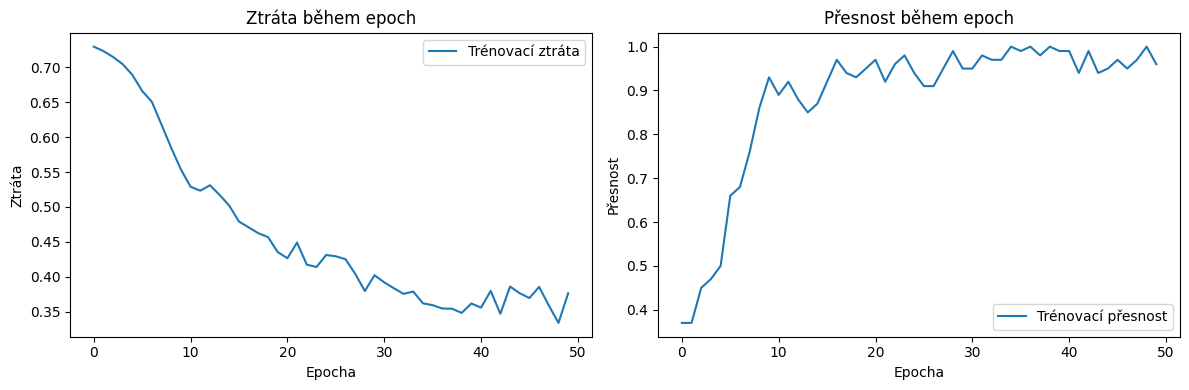

In [56]:
plot_training_history(lstm_history)


============= Test Results =============
Overall Accuracy: 78.00%

Classification Report:
              precision    recall  f1-score   support

      Normal     0.6346    0.9167    0.7500        36
    Abnormal     0.9375    0.7031    0.8036        64

    accuracy                         0.7800       100
   macro avg     0.7861    0.8099    0.7768       100
weighted avg     0.8285    0.7800    0.7843       100



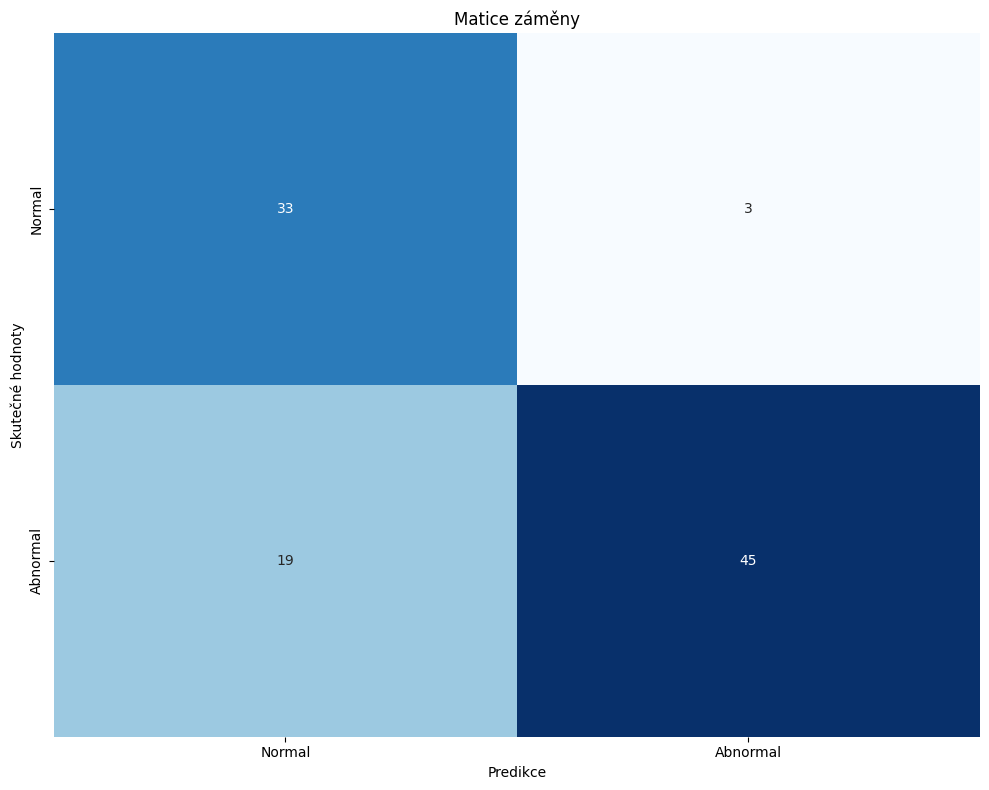

In [57]:
lstm_metrics = evaluate_model(lstm_model, test_loader, device, class_names)

### LSTM Bidirectional

In [58]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(BidirectionalLSTMModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. Bidirectional LSTM Processor
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size // 2),  # Multiply by 2 for bidirectional
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()  # Added Sigmoid activation like other models
        )

    def forward(self, x):     
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension
        
        # 2. Prepare for LSTM (add sequence dimension back)
        lstm_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]      

        # 3. LSTM Processing
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))
        lstm_out = lstm_out[:, -1, :]  # Last timestep
        
        # 4. Classification
        logits = self.classifier(lstm_out)
        return logits


In [59]:
model = BidirectionalLSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
BidirectionalLSTMModel                   [16, 1, 96]               [16, 2]                   --
├─Sequential: 1-1                        [16, 1, 96]               [16, 64, 1]               --
│    └─Conv1d: 2-1                       [16, 1, 96]               [16, 64, 96]              512
│    └─BatchNorm1d: 2-2                  [16, 64, 96]              [16, 64, 96]              128
│    └─ReLU: 2-3                         [16, 64, 96]              [16, 64, 96]              --
│    └─MaxPool1d: 2-4                    [16, 64, 96]              [16, 64, 48]              --
│    └─Conv1d: 2-5                       [16, 64, 48]              [16, 128, 48]             41,088
│    └─BatchNorm1d: 2-6                  [16, 128, 48]             [16, 128, 48]             256
│    └─ReLU: 2-7                         [16, 128, 48]             [16, 128, 48]             --
│    └─MaxPool1d: 2-8       

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [61]:
bidirectional_lstm_model, bidirectional_lstm_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6820 |    58.00% | ✓
  2/50  |     0.6819 |    57.00% | 
  3/50  |     0.6697 |    66.00% | ✓
  4/50  |     0.6717 |    68.00% | ✓
  5/50  |     0.6528 |    73.00% | ✓
  6/50  |     0.6309 |    73.00% | 
  7/50  |     0.5906 |    84.00% | ✓
  8/50  |     0.5753 |    83.00% | 
  9/50  |     0.5465 |    88.00% | ✓
 10/50  |     0.5241 |    88.00% | 
 11/50  |     0.5194 |    92.00% | ✓
 12/50  |     0.4957 |    95.00% | ✓
 13/50  |     0.4854 |    90.00% | 
 14/50  |     0.4799 |    91.00% | 
 15/50  |     0.4662 |    94.00% | 
 16/50  |     0.4528 |    95.00% | 
 17/50  |     0.4399 |    95.00% | 
 18/50  |     0.4367 |    97.00% | ✓
 19/50  |     0.4324 |    96.00% | 
 20/50  |     0.4172 |    97.00% | 
 21/50  |     0.4179 |    96.00% | 
 22/50  |     0.4025 |    98.00% | ✓
 23/50  |     0.4091 |    96.00% | 
 24/50  |     0.3914 |    97.00% | 
 25/50  |     0.3884 |   

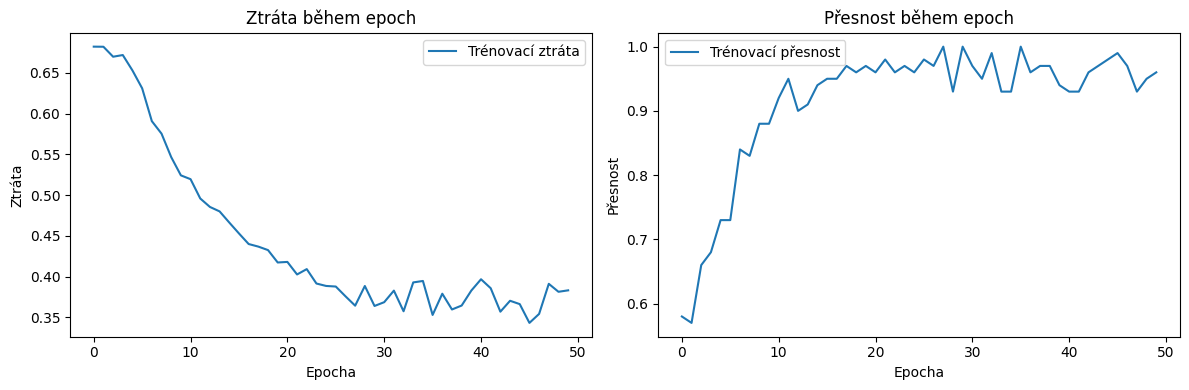

In [62]:
plot_training_history(bidirectional_lstm_history)


============= Test Results =============
Overall Accuracy: 88.00%

Classification Report:
              precision    recall  f1-score   support

      Normal     0.8158    0.8611    0.8378        36
    Abnormal     0.9194    0.8906    0.9048        64

    accuracy                         0.8800       100
   macro avg     0.8676    0.8759    0.8713       100
weighted avg     0.8821    0.8800    0.8807       100



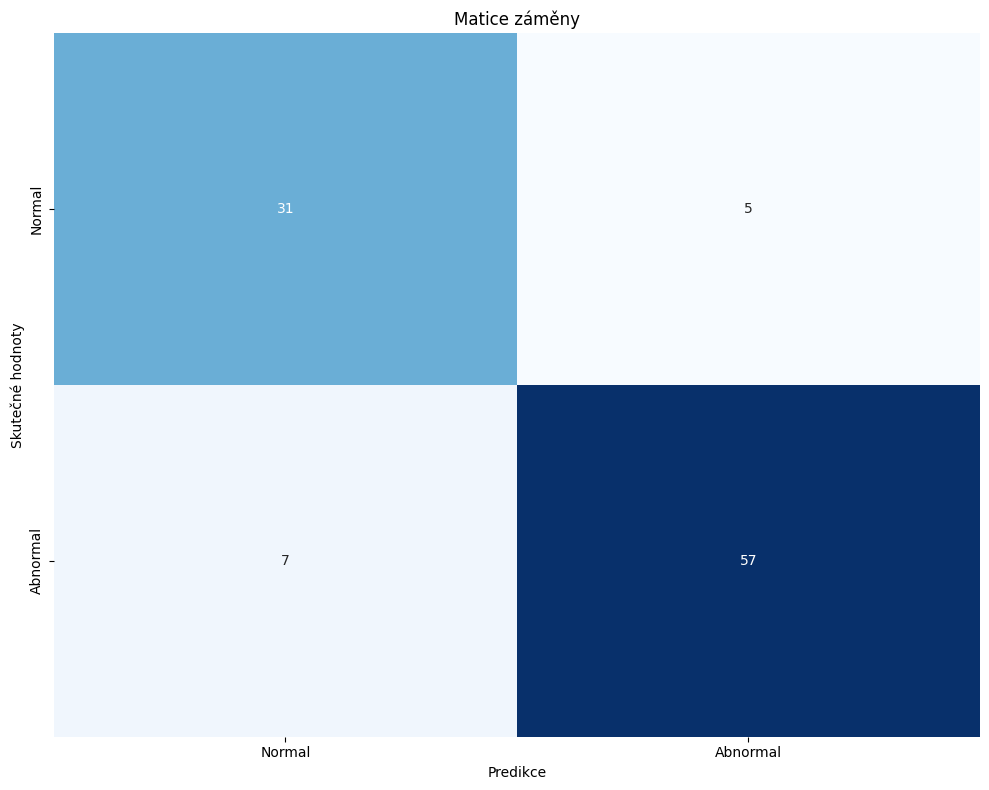

In [63]:
bidirectional_lstm_metrics = evaluate_model(bidirectional_lstm_model, test_loader, device, class_names)

### CNN

In [64]:
class CNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(CNNModel, self).__init__()
        
        # Feature extraction with CNN blocks - reduced to 3 blocks
        self.features = nn.Sequential(
            # Block 1
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()  
        )

    def forward(self, x):          
        # Feature extraction
        x = self.features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        return x


In [65]:
model = CNNModel(input_channels=1, num_classes=num_classes).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNNModel                                 [16, 1, 96]               [16, 2]                   --
├─Sequential: 1-1                        [16, 1, 96]               [16, 256, 1]              --
│    └─Conv1d: 2-1                       [16, 1, 96]               [16, 64, 96]              512
│    └─BatchNorm1d: 2-2                  [16, 64, 96]              [16, 64, 96]              128
│    └─ReLU: 2-3                         [16, 64, 96]              [16, 64, 96]              --
│    └─MaxPool1d: 2-4                    [16, 64, 96]              [16, 64, 48]              --
│    └─Conv1d: 2-5                       [16, 64, 48]              [16, 128, 48]             41,088
│    └─BatchNorm1d: 2-6                  [16, 128, 48]             [16, 128, 48]             256
│    └─ReLU: 2-7                         [16, 128, 48]             [16, 128, 48]             --
│    └─MaxPool1d: 2-8       

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
cnn_model, cnn_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6777 |    64.00% | ✓
  2/50  |     0.6516 |    69.00% | ✓
  3/50  |     0.6153 |    69.00% | 
  4/50  |     0.5780 |    69.00% | 
  5/50  |     0.5642 |    69.00% | 
  6/50  |     0.5461 |    69.00% | 
  7/50  |     0.5226 |    71.00% | ✓
  8/50  |     0.5107 |    78.00% | ✓
  9/50  |     0.4923 |    84.00% | ✓
 10/50  |     0.4918 |    86.00% | ✓
 11/50  |     0.4898 |    82.00% | 
 12/50  |     0.4350 |    90.00% | ✓
 13/50  |     0.4378 |    91.00% | ✓
 14/50  |     0.4329 |    89.00% | 
 15/50  |     0.4075 |    91.00% | 
 16/50  |     0.4065 |    92.00% | ✓
 17/50  |     0.4068 |    93.00% | ✓
 18/50  |     0.4199 |    88.00% | 
 19/50  |     0.3845 |    94.00% | ✓
 20/50  |     0.3954 |    91.00% | 
 21/50  |     0.4019 |    92.00% | 
 22/50  |     0.4007 |    91.00% | 
 23/50  |     0.3886 |    93.00% | 
 24/50  |     0.3642 |    96.00% | ✓
 25/50  |     0.3784 | 

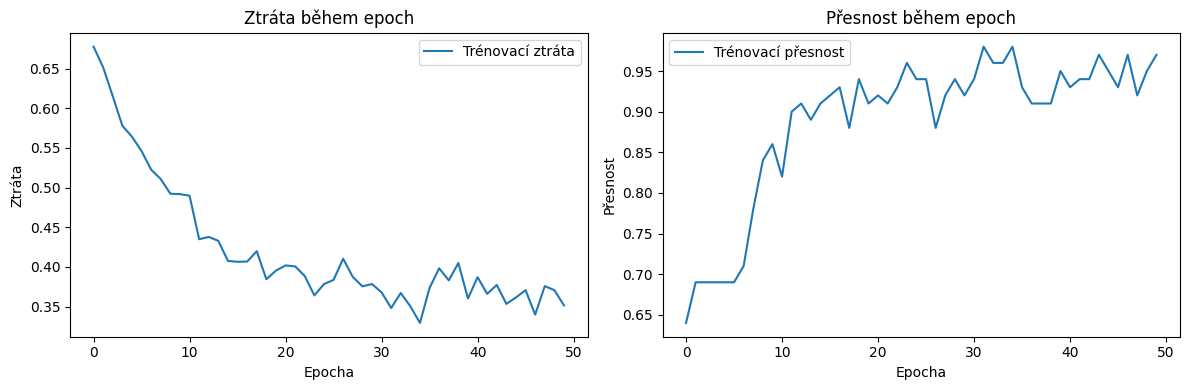

In [68]:
plot_training_history(cnn_history)


============= Test Results =============
Overall Accuracy: 85.00%

Classification Report:
              precision    recall  f1-score   support

      Normal     0.7561    0.8611    0.8052        36
    Abnormal     0.9153    0.8438    0.8780        64

    accuracy                         0.8500       100
   macro avg     0.8357    0.8524    0.8416       100
weighted avg     0.8580    0.8500    0.8518       100



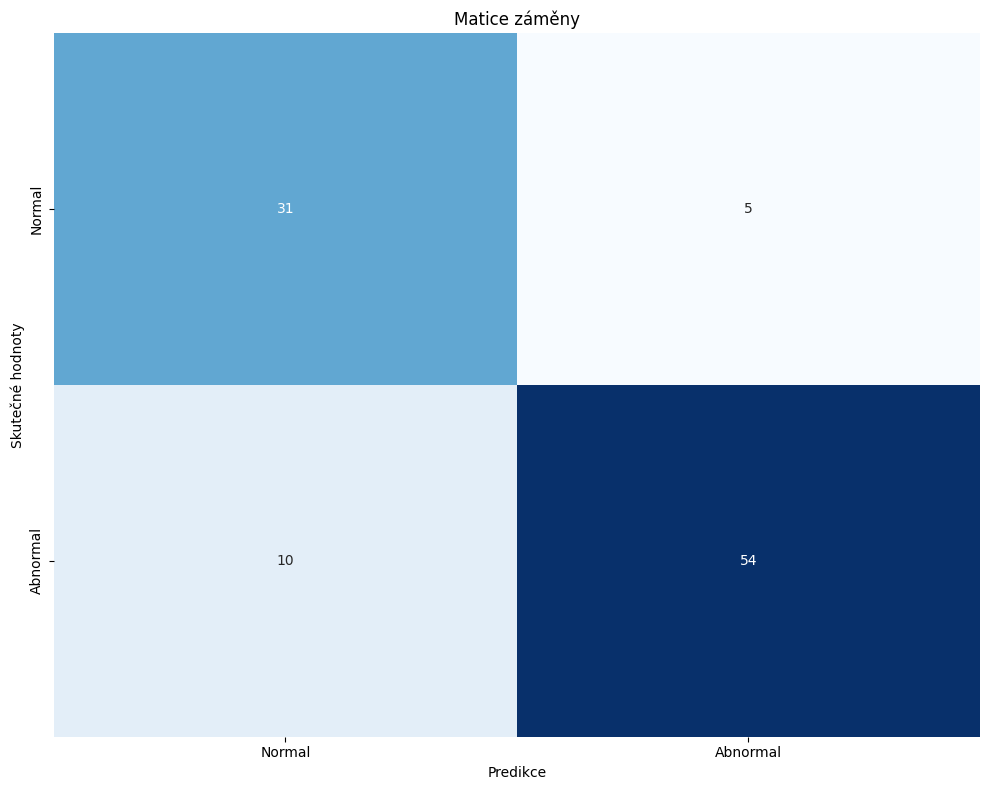

In [69]:
cnn_metrics = evaluate_model(cnn_model, test_loader, device, class_names)

# Výsledky

## Porovnání výsledků klasických modelů

In [70]:
classic_results = {
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        classification_report(y_test, y_pred_dt, output_dict=True)['accuracy'],
        classification_report(y_test, y_pred_rf, output_dict=True)['accuracy'],
        classification_report(y_test, y_pred_gb, output_dict=True)['accuracy']
    ],
}

results_classic = pd.DataFrame(classic_results)
results_classic = results_classic.set_index('Model')
results_classic = results_classic.sort_values(by='Accuracy', ascending=False)

In [71]:
results_classic

,Accuracy
Model,
Decision Tree,0.82
Random Forest,0.81
Gradient Boosting,0.81


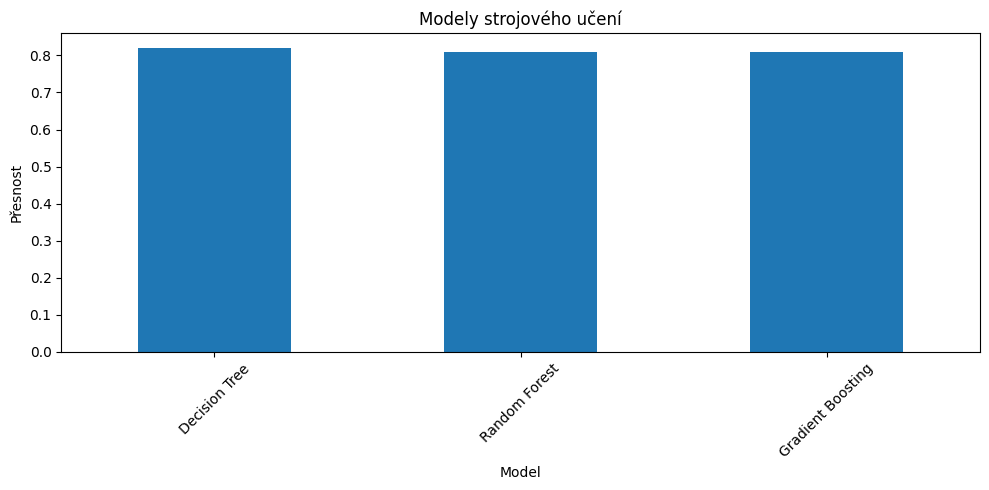

In [72]:
plt.figure(figsize=(10, 5))
results_classic['Accuracy'].plot(kind='bar')
plt.title('Modely strojového učení')
plt.ylabel('Přesnost')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Porovnání výsledků neuronových sítí


In [73]:
nn_results = {
    'Model': ['RNN', 'GRU', 'LSTM', 'Bidirectional LSTM', 'CNN'],
    'Accuracy': [
        rnn_metrics['Accuracy'],
        gru_metrics['Accuracy'],
        lstm_metrics['Accuracy'],
        bidirectional_lstm_metrics['Accuracy'],
        cnn_metrics['Accuracy']
    ],
    'Precision': [
        rnn_metrics['Precision'],
        gru_metrics['Precision'],
        lstm_metrics['Precision'],
        bidirectional_lstm_metrics['Precision'],
        cnn_metrics['Precision']
    ],
    'Recall': [
        rnn_metrics['Recall'],
        gru_metrics['Recall'],
        lstm_metrics['Recall'],
        bidirectional_lstm_metrics['Recall'],
        cnn_metrics['Recall']
    ],
    'F1-score': [
        rnn_metrics['F1-score'],
        gru_metrics['F1-score'],
        lstm_metrics['F1-score'],
        bidirectional_lstm_metrics['F1-score'],
        cnn_metrics['F1-score']
    ]
}

In [74]:
results_nn = pd.DataFrame(nn_results)
results_nn = results_nn.set_index('Model')

In [75]:
results_nn_sorted = results_nn.sort_values(by='Accuracy', ascending=False)
results_nn_sorted

,Accuracy,Precision,Recall,F1-score
Model,,,,
Bidirectional LSTM,0.88,0.882071,0.88,0.880669
RNN,0.87,0.869363,0.87,0.869588
GRU,0.86,0.858895,0.86,0.859077
CNN,0.85,0.857958,0.85,0.851821
LSTM,0.78,0.828462,0.78,0.784286


<Figure size 1200x600 with 0 Axes>

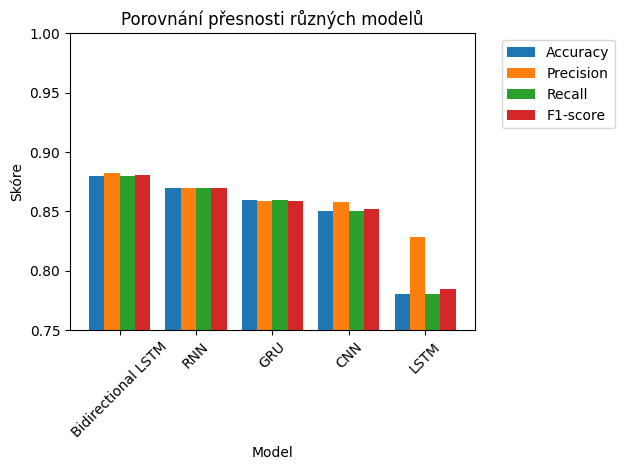

In [76]:
plt.figure(figsize=(12, 6))
results_nn_sorted.plot(kind='bar', width=0.8)
plt.title('Porovnání přesnosti různých modelů')
plt.ylabel('Skóre')
plt.ylim(0.75, 1.0)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()